In [1]:
!pip install wandb

# **Import Libraries**

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import os
from numpy import cov
from glob import glob
from numpy import trace
from numpy import iscomplexobj
from PIL import Image,ImageEnhance
from time import time
from numpy.random import random
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
import wandb
from tensorflow.keras.applications import VGG19,VGG16
import keras 
import tensorflow as tf
from keras.layers import Input
from keras.models import Model
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model
from keras.initializers import RandomNormal
from keras.layers import concatenate,MaxPooling2D
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from scipy.linalg import sqrtm
import tensorflow_hub as hub
import cv2
from random import randint

# **PARAMS AND CONSTANTS**

In [99]:
SCRATCH_PATH= '/kaggle/input/scratch/ScratchMarks'
DATAPATH= "/kaggle/input/humanface8000/landscape Images/color"
LABELPATH= "/kaggle/input/humanface8000/landscape Images/gray"
THRESHOLD=50
IMG_H=256
IMG_W=256
KERNEL=5
SCALE_FACTOR=2
EPOCH=30
BATCH_SIZE=4


In [100]:
#wandb.login()

In [101]:
print(tf.__version__)
print(keras.__version__)

2.13.0
2.13.1


# REQURIED FILES

In [102]:
file_path="/kaggle/input/humanface8000/landscape Images/color"
gt_path="/kaggle/input/humanface8000/landscape Images/gray"

all_files=[]
train_files=[]
val_files=[]
for file in os.listdir(file_path):
    all_files.append(file)
    


In [103]:
train_files=all_files[:1200]
val_files=all_files[1200:1400]
scratch_files=glob("/kaggle/input/scratch/ScratchMarks/*.jpeg")
print(len(all_files))
print(len(train_files))
print(len(val_files))
print(len(scratch_files))

8164
1200
200
5


# MASK SYNTHESSIS AND DATALOADER

In [142]:
class ImageSynthesis:
    def __init__(self,threshold,height,width,kernel,scale):
        
        self.threshold=threshold # threshold value for creating a boundary between scratch marks
        self.height=height # image height
        self.width=width # image width
        self.kernel=kernel #kernel size
        self.scale=scale #scale
    @staticmethod
    def read_image(image_path):
        """
        
        inputs: IMG_PATH->str
        Description : Reads image,resizes converts image to RGB format
        returns: image -> numpy array
        
        """
        img= cv2.imread(image_path)
        img= cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img= cv2.resize(img, (IMG_W,IMG_H))
        return img

    def add_noise(self,image):
        """
        
        inputs: image -> numpy array
        Description : Adds random noise in the image
        returns: image -> numpy array
        
        """
        mean,stddev = 0,100
        noise = np.zeros(image.shape, np.uint8)
        cv2.randn(noise, mean, stddev)
        noisy_img = cv2.add(image, noise)
        return noisy_img
    
    def vignette(self,input_image):
        
        """
        
        inputs: image ->numpy array
        Description : the modle performs an operation of a filter to increase darkness
        returns: image -> numpy array
        
        """
        rows, cols = input_image.shape[:2]
        X_resultant_kernel = cv2.getGaussianKernel(cols,240)
        Y_resultant_kernel = cv2.getGaussianKernel(rows,240)

        resultant_kernel = Y_resultant_kernel * X_resultant_kernel.T
        mask = 255 * resultant_kernel / np.linalg.norm(resultant_kernel)
        output = np.copy(input_image)

        # applying the mask to each channel in the input image
        for i in range(3):
            output[:,:,i] = output[:,:,i] * mask
        return output

    def sepia_filter_PIL(self,image):
        """
        
        inputs: image-> numpy array
        Description : the module performs an operation of a filter (sepia) to 
                      give a vintage look to the image
        returns: image -> PIL image
        
        """
        factor=1.5
        img = Image.fromarray(image)
        enhancer = ImageEnhance.Contrast(img)
        width, height = img.size
        pixels = img.load() # create the pixel map
        for py in range(height):
            for px in range(width):
                r, g, b = img.getpixel((px, py))
                pixels[px, py] = (min(255, int(0.393 * r + 0.769 * g + 0.189 * b)), \
                                  min(255, int(0.349 * r + 0.686 * g + 0.168 * b)), \
                                  min(255, int(0.272 * r + 0.534 * g + 0.131 * b)))

        img= enhancer.enhance(factor)
        return img


    def sepia_filter_np(self,image_path):
        """
        
        inputs: image-> numpy array
        Description : the module performs an operation of a filter (sepia) to 
                      give a vintage look to the image
        returns: image -> numpy array
        
        """
        im = plt.imread(image_path)
        im = im / im.max()    
        R, G, B = im[...,0], im[...,1], im[...,2]
        im_out = np.dstack((0.393 * R + 0.769 * G + 0.189 * B, \
                            0.349 * R + 0.686 * G + 0.168 * B, \
                            0.272 * R + 0.534 * G + 0.131 * B))
        im_out = np.clip(im_out, 0, 1)
        return (255*im_out).astype(np.uint8)

    
    def hightResolutionImage(self,image_path):
        """
        
        inputs: image-> IMG_PATH -> str
        Description : Reads the image and gives it a vintage look (Sepia filter)
        returns: image -> PIL image
        """
        image=self.read_image(image_path)
        sepi_filter=self.sepia_filter_PIL(image)
        ret_image=np.array(sepi_filter)
        return ret_image
    
    def create_binary_image(self,image_path, threshold_value):
        """
        
        inputs: image-> IMG_PATH -> str, threshold_value -> int
        Description : Creates a binary image of the scratch image 
                      based on a threshold value 
        returns: image -> numpy array
        """
        original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if original_image is None:
            print(f"Error: Unable to read the image at '{image_path}'. Please check the file path.")
            return
        original_image=cv2.resize(original_image,(self.height,self.width))
        binary_mask = np.zeros_like(original_image)
        binary_mask[original_image > self.threshold] = 255
        #print(np.unique(binary_mask))
        return binary_mask
    def generate_mask(self,path,scratch_img):
        
        """
        
        inputs: image-> IMG_PATH -> str, scratch_img-> numpy array
        Description : THe function is responsible for the Old image synthesis operation
                      Steps:
                          >read image
                          > add the scratch marks in the original image by replacing the
                            pixels having 255 value
                          > add vigentte effect to give some dark and degraded look
                          > add sepia filter for the classic old look
                          > add gaussian blurr to make the image blurry
                          > reduce the quality of the image by scaling down and
                            then scaling up to original dimmensions
                            
        returns: image -> numpy image
        """
        orig_img=self.read_image(path)
        orig_img[scratch_img==255]=255
        orig_img=self.add_noise(orig_img)
        orig_img=self.vignette(orig_img)
        im_out_PIL = self.sepia_filter_PIL(orig_img) 
        orig_img=np.array(im_out_PIL)
        #orig_img=vignette(orig_img)
        blurred_image = cv2.GaussianBlur(orig_img, (self.kernel, self.kernel), 0)
        h,w,_=blurred_image.shape
        n_h,n_w=h//self.scale,w//self.scale
        reduce_img=cv2.resize(blurred_image,(n_h,n_w))
        final_img=cv2.resize(reduce_img,(h,w))
        return final_img

    
class DataGenerator(ImageSynthesis):

    def __init__(self,real_path,impaint_path,batch_size,files,threshold,height,width,kernel,scale,scratch_files,augment=False):
        #Fetch modules from Parent Class
        super().__init__(threshold,height,width,kernel,scale)
        self.batch_size=batch_size #batch size
        self.real_path=real_path  #path of color images
        self.impaint_path=impaint_path #path of impainting images
        self.files=files  #list containing name of all the files
        self.augment=augment #boolean wether to augment or not
        self.scratch_list=scratch_files #list of scratch mark image files
  
    def read_image(self,path):
        """
        
        inputs: IMG_PATH->str
        Description : Reads image,resizes converts image to RGB format
        returns: image -> numpy array
        
        """
        img=cv2.imread(path)
        img=cv2.resize(img,(256,256))#resize image to 128*128
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)#BGR to RGB
        return img
    def flip_transform(self,img):
        #Horizotal flip 
        """
        
        inputs: image -> numpy
        Description : Flips
        returns: image -> numpy array
        
        """
        return cv2.flip(img,1)
    
    def image_preprocessing(self,img):
        #scale the image down between 0 to 1
        """
        
        inputs: image -> numpy
        Description : scales the image within the range  0-1
        returns: image -> numpy array
        
        """
        img=img/255.0
        return img
    #old image restoration
    def forward(self,start_index):
        """
        
        inputs: start_indx -> int
        Description : This module is reponsible for generating batches of Image and Mask
                      based on the index it iterates over the entire list of files and returns 
                      a fixed batch of images and masks
                      
                      
        Note: This module return mask as the synthesized old and degraded images
        returns: (image,image) -> numpy array
        
        """
        data,mask=[],[]
        for indx in self.files[start_index:start_index+batch_size]:
            r_path=os.path.join(self.real_path,indx)
            srtch_path=self.scratch_list[randint(0, len(self.scratch_list) - 1)]
            scratch_img=self.create_binary_image(srtch_path,self.threshold)
            old_mask=self.image_preprocessing(self.generate_mask(r_path,scratch_img))
            real_image=self.image_preprocessing(self.hightResolutionImage(r_path))
            data.append(real_image)
            mask.append(old_mask)
            if self.augment==True:
                flip1=self.flip_transform(real_image)
                flip2=self.flip_transform(old_mask)
                data.append(flip1)
                labels.append(flip2)
        data=np.array(data)
        mask=np.array(mask)
        return mask,data
            
    #image impainting
    def __getitem__(self,start_index):
        """
        
        inputs: start_indx -> int
        Description : This module is reponsible for generating batches of Image and Mask
                      based on the index it iterates over the entire list of files and returns 
                      a fixed batch of images and masks
                      
                      
        Note: This module return mask as the impainting images
        returns: (image,image) -> numpy array
        
        """
        
        data=[]
        labels=[]
        for indx in self.files[start_index:start_index+batch_size]:
            r_path=os.path.join(self.real_path,indx)
            c_path=os.path.join(self.impaint_path,indx)
            real_img=self.image_preprocessing(self.read_image(r_path))
            impainted_img=self.image_preprocessing(self.read_image(c_path))
            data.append(real_img)
            labels.append(impainted_img)
            if self.augment==True:
                flip1=self.flip_transform(real_img)
                flip2=self.flip_transform(impainted_img)
                data.append(flip1)
                labels.append(flip2)
        data=np.array(data)
        labels=np.array(labels)
        return labels,data
    
    

In [150]:
batch_size=4
train_gen=DataGenerator(file_path,gt_path,batch_size,train_files,THRESHOLD,IMG_H,IMG_W,KERNEL,SCALE_FACTOR,scratch_files)
val_gen=DataGenerator(file_path,gt_path,batch_size,val_files,THRESHOLD,IMG_H,IMG_W,KERNEL,SCALE_FACTOR,scratch_files)

In [151]:
x,y=val_gen.forward(0)

In [154]:
def Generator(x,y,z):
    """
    Input : (x,y,z) -> (int,int,int) :(H,W,C)
    Description : Generator design of the GAN 
                   Having a U-Net kind architecture
    returns : model -> Keras model object
    
    """
    inputs=Input(shape=(x,y,z))
    init = RandomNormal(stddev=0.02)
    c1=Conv2D(64,(4,4),strides=(2,2),activation="relu",kernel_initializer=init,padding="same")(inputs)
    c1=LeakyReLU(alpha=0.2)(c1)#(64,64,64)

    c2 = Conv2D(128, (4,4),strides=(2,2), kernel_initializer=init, padding='same')(c1)
    c2=BatchNormalization()(c2,training=True)#(128,32,32)
    c2=LeakyReLU(alpha=0.2)(c2)

    c3 = Conv2D(256 ,(4,4), strides=(2,2) ,kernel_initializer=init, padding='same')(c2)
    c3=BatchNormalization()(c3,training=True)#(256,16,16)
    c3=LeakyReLU(alpha=0.2)(c3)

    c4 = Conv2D(512, (4,4), strides=(2,2), kernel_initializer=init, padding='same')(c3)
    c4=BatchNormalization()(c4,training=True)#(512,8,8)
    c4=LeakyReLU(alpha=0.2)(c4)

    c5 = Conv2D(512, (4,4),strides=(2,2),  kernel_initializer=init, padding='same')(c4)
    c5=BatchNormalization()(c5,training=True)#512,4,4
    c5=LeakyReLU(alpha=0.2)(c5)  

    c6 = Conv2D(512, (4,4), strides=(2,2),kernel_initializer=init, padding='same')(c5)
    c6=BatchNormalization()(c6,training=True)#512,2,2
    c6=LeakyReLU(alpha=0.2)(c6)  

    c7 = Conv2D(512, (4,4), strides=(2,2), kernel_initializer=init, padding='same')(c6)
    c7=BatchNormalization()(c7,training=True)#512,1,1
    c7=LeakyReLU(alpha=0.2)(c7)  

    #b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(c7)
    #b = Activation('relu')(c7)  

    d1 = Conv2DTranspose(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(c7)
    d1=BatchNormalization()(d1,training=True)#512*2*2
    d1=Dropout(0.5)(d1,training=True)
    d1=Concatenate()([d1, c6])   
    d1=Activation("relu")(d1)

    d2 =Conv2DTranspose(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d1)
    d2=BatchNormalization()(d2,training=True)#512*4*4
    d2=Dropout(0.5)(d2,training=True)
    d2=Concatenate()([d2,c5])  
    d2=Activation("relu")(d2)

    d3 = Conv2DTranspose(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d2)
    d3=BatchNormalization()(d3,training=True)#512*8*8
    d3=Dropout(0.5)(d3,training=True)
    d3=Concatenate()([d3, c4])   
    d3=Activation("relu")(d3)

    d4 = Conv2DTranspose(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d3)
    d4=BatchNormalization()(d4,training=True)#512*16*16
    #d4=Dropout(0.5)(d4,training=True)
    d4=Concatenate()([d4, c3])   
    d4=Activation("relu")(d4) 

    d5 = Conv2DTranspose(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d4)
    d5=BatchNormalization()(d5,training=True)#256*32*32
    #d5=Dropout(0.5)(d5,training=True)
    d5=Concatenate()([d5, c2])   
    d5=Activation("relu")(d5) 

    d6 = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d5)
    d6=BatchNormalization()(d6,training=True)#128*64*64
    #d6=Dropout(0.5)(d6,training=True)
    d6=Concatenate()([d6, c1])   
    d6=Activation("relu")(d6)     

    #d7 = Conv2DTranspose(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d6)
    #d7=BatchNormalization()(d7,training=True)
    #d7=Concatenate()([d7, c1])   
    #$d7=Activation("relu")(d7)    

    f = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d6) 
    out_image = Activation('tanh')(f) #3,128,128

    model = Model(inputs, out_image)
    return model


In [155]:
def discriminator(h,w,c):
    """
    Input : (x,y,z) -> (int,int,int) :(H,W,C)
    Description : Discriminator design of the GAN 
                  it is like classification architecture
                  but the out shape is of (16x16) instead of 
                  classifying the whole image it classifies different section of
                  image which provides better understanding in terms of where 
                  improvement need to be made
    returns : model -> Keras model object
    
    """
    init = RandomNormal(stddev=0.02) #kerenl initialiser
      
    
    in_src_image = Input(shape=(h,w,c))  
    
    in_target_image = Input(shape=(h,w,c))   
      
    
    merged = Concatenate()([in_src_image, in_target_image])
      
    
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)

    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    #d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    #d = BatchNormalization()(d)
    #d = LeakyReLU(alpha=0.2)(d)
    
    d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)

    model = Model([in_src_image, in_target_image], patch_out)

      
    model.compile(loss='binary_crossentropy', optimizer="adam", loss_weights=[0.5])
    return model


In [156]:
def vgg_model(h,w,c):
        """
    Input : (x,y,z) -> (int,int,int) :(H,W,C)
    Description : VGG-19 is a model trained on imagenet dataset which contains high 
                  resolution images 
                  We take a take the top 10 layers of that model with its trained weights
    returns : model -> Keras model object
    
    """
    vgg=tf.keras.applications.vgg19.VGG19(weights="imagenet",include_top=False, input_shape=(h,w,c))
    return Model(inputs=vgg.inputs, outputs=vgg.layers[9].output)

In [157]:
vgg=vgg_model(256,256,3)
vgg.trainable=False

In [158]:
def GAN(gen,dis,h,w,c,vgg):
        """
        Input : gen -> keras model ,dis->keras model,(x,y,z) -> (int,int,int) :(H,W,C)
        Description : Its a combined model we join the generator and discriminator
                      because we want to train the discriminator to train separately but the 
                      generator (adverserial learing + perceptual + generator loss)
                       
                      we use weighted loss for the [adverserial_losss, geenrator_loss, perceptiual_loss]
        returns : model -> Keras model object

    """
    for layer in dis.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False         
    inp1=Input(shape=(h,w,3))
    #inp2=Input(shape=(h,w,3))
    out=gen(inp1)
    vgg_out=vgg(out)
    main_out=dis([inp1,out])
    #print(main_out)
    #print(out)
    model=Model(inp1,[main_out,out,vgg_out])
    #we are using two loss function the binary cross entropy is mainly for the real-fake prediction 
    #the mse is the meas square loss which is for the loss calc between the ground truth and genenrated image
    #we want to put more weightge on the image generated to be more like the gt so we keep the weightage of it to be 100 times the real
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002,beta_1=0.5),loss=["binary_crossentropy","mse","mse"],loss_weights=[1,100,1])
    return model


In [185]:
def evaluate(gen,dis,comb,vgg,batch_size,val_data,val_files):
    """
    Input : gen,dis,comb,vgg-> Keras model, batch_size->int,val_data->object,val_files->list
    Description : Evaluation function 
    returns : float,float,float
    
    """
    batch_step=int(len(val_files)/batch_size)
    s=0
    discrim_loss=0
    genloss=0
    percep_loss=0
    for batch in range(batch_step):
        x_real,y_real=val_data.forward(s)
        dis_loss=comb.evaluate(x_real,verbose=False)
        #print(dis_loss)
        fak_pred=np.ones((batch_size,16,16,1))
        gen_pred=gen.predict(x_real)
        feat=vgg.predict(y_real)

        #print(feat.shape)
        gan_loss,_,_,perceptual_loss=comb.evaluate(x_real,[fak_pred,y_real,feat],verbose=False)
        s=s+batch_size
        discrim_loss+=sum(dis_loss)
        genloss+=gan_loss
        percep_loss+=perceptual_loss      

    discrim_loss=discrim_loss/batch_step
    percep_loss=percep_loss/batch_step
    genloss=genloss/batch_step
    print('val_dis_loss[%.3f] val_generator_loss[%.3f] val_perceptual loss[%.3f]' % (discrim_loss, genloss,percep_loss)   )
    return discrim_loss, genloss,percep_loss
        

In [160]:
#evaluate(gen,dis,model,vgg,5,val_gen,val_files)

In [191]:

def train(gen,dis,comb,vgg,batch_size,epochs,val_data,train_files,train_gen,val_gen,val_files):
    """
    Input : gen,dis,comb,vgg-> Keras model, batch_size,epochs->int,train_gen,val_gen->object,train,val_files->list
    Description : Training function 
    returns : None
    
    """    
    

    discrim=[]
    generator_loss=[]
    half_batch=batch_size//2


    #logs = {}
    #callbacks.on_train_begin(logs=logs)
    
    batch_step=int(len(train_files)/batch_size)
    #print(batch_step)
    val_generate=[]
    for epoch in range(epochs):
        s=0
        discrim_loss=0
        genloss=0
        percep_loss=0
        for batch in range(batch_step):
            
            x_real,y_real=train_gen.forward(s)
            #print(len(y_real))
            x_half=x_real[:half_batch]
            y_half=y_real[:half_batch]

            dis.trainable=True
            d_loss_real=dis.train_on_batch([y_real,x_real],np.ones((batch_size,16,16,1)))#training the discriminator in real images
            
            fak_pred=np.ones((batch_size,16,16,1))
            dis.trainable=False
            #now we will try out generator 
            #and to fool the discriminator we pass the generated image labels as the real image
            gen_pred=gen.predict(x_real)
            feat=vgg.predict(y_real)
            
            #print(feat.shape)
            gan_loss,_,_,perceptual_loss=comb.train_on_batch(x_real,[fak_pred,y_real,feat])
            
            s=s+batch_size
            #dis_loss=(d_loss_fake+d_loss_real)/2
            dis_loss=d_loss_real
            discrim_loss+=dis_loss
            genloss+=gan_loss
            percep_loss+=perceptual_loss
            val_disloss,val_genloss,val_perceploss=evaluate(gen,dis,comb,vgg,batch_size,val_gen,val_files)
            wandb.log({
                "batch": epoch*(batch+1),
                "train_GAN_loss": gan_loss,
                "train_dis_loss": dis_loss,
                "train_percep_loss":perceptual_loss,
                "val_gen_loss":val_genloss,
                "val_dis_loss":val_disloss,
                "val_perceptual_loss":val_perceploss,
            })
        discrim_loss=discrim_loss/batch_step
        percep_loss=percep_loss/batch_step
        genloss=genloss/batch_step

        #callback.on_batch_end(epoch, logs=gen.history)
#         for i,file in enumerate(val_data):
#             img=read_transform(file)
#             val=gen.predict(np.expand_dims(img,axis=0))
#             val_generate.append(val[0])
#             #images = wandb.Image(val[0])
#             #wandb.log({"image_{}".format(i):images})

#         if epoch%5==0:
#             path="./checkpoint/model-"+str(epoch)+".ckpt"
#             gen.save_weights(path)
            
        print('epoch> %d,dis_loss[%.3f] generator_loss[%.3f] perceptual loss[%.3f]' % (epoch+1, discrim_loss, genloss,percep_loss)   )
    wandb.finish()
    #return val_gen

In [192]:


gen=Generator(256,256,3)
#print(gen.summary())
gen.compile(optimizer="adam",loss="binary_crossentropy",run_eagerly=True)
dis=discriminator(256,256,3)
model=GAN(gen,dis,256,256,1,vgg)
model.summary()


Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_23 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 model_15 (Functional)       (None, 256, 256, 3)          4866438   ['input_23[0][0]']            
                                                          7                                       
                                                                                                  
 model_16 (Functional)       (None, 16, 16, 1)            2771393   ['input_23[0][0]',            
                                                                     'model_15[0][0]']            
                                                                                           

In [193]:
#gen.summary()

In [194]:
run=wandb.init(project='PhotoRestoration', job_type='train')


wandb: Currently logged in as: pranay-009. Use `wandb login --relogin` to force relogin


In [197]:
#train
val_gen2=train(gen,dis,model,vgg,batch_size,5,None,train_files,train_gen,val_gen,val_files)
# #wandb.finish()

In [196]:
wandb.finish()
val_files[0]

batch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_GAN_loss,▆█▇▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_dis_loss,█▅▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_percep_loss,▄█▇▆▃▃▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▂▁▁
val_dis_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_gen_loss,█▇▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_perceptual_loss,█▇▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch,0
train_GAN_loss,15.57973
train_dis_loss,1e-05
train_percep_loss,13.74404


'46485.jpg'

# Visulaize Generated results

1/1 [==============================] - 0s 65ms/step


(-0.5, 255.5, 255.5, -0.5)

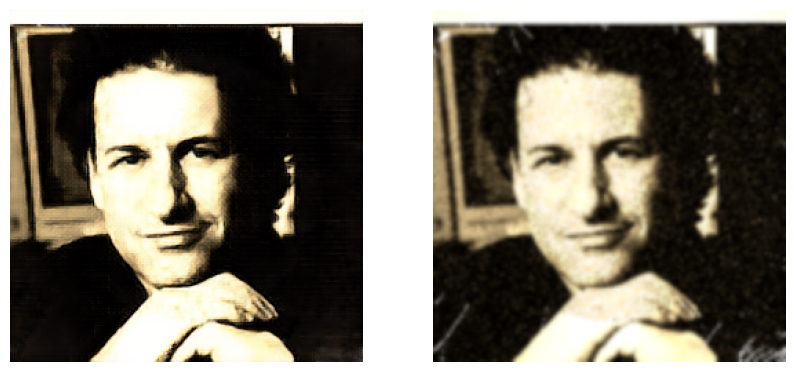

In [200]:
paath="/kaggle/input/humanface8000/landscape Images/color/10006.jpg"

image,mask=val_gen.forward(6)
image=image[1]
image=np.expand_dims(image,axis=0)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
y=gen.predict(image)
plt.imshow(y[0])
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(image[0])
plt.axis("off")

In [179]:
#save model
gen.save(r"/kaggle/working/model.keras")

In [199]:
gen.load_weights(r"/kaggle/working/model.keras")

Clone model

In [201]:
load_gen=Generator(256,256,3)
load_gen.load_weights(r"/kaggle/working/model.keras")

# Inference Module

In [208]:
obj=ImageSynthesis(THRESHOLD,IMG_H,IMG_W,KERNEL,SCALE_FACTOR)
def inference(img_path,model,plot=False):
    """
    Inputs : image_path -> str
             model -> Keras Model
             Plot-> boolen
    Description : Simple Prediction Pipeline
    
    returns prediction (geenrated image)
    """
  
    img=obj.create_binary_image(scratch_files[randint(0, len(scratch_files) - 1)],THRESHOLD)
    org=obj.generate_mask(img_path,img)/255.0
    image=np.expand_dims(org,axis=0)
    prediction=model.predict(image)
    if plot==True:
        plt.figure(figsize=(10,10))
        plt.subplot(1,2,1)
        plt.imshow(prediction[0])
        plt.axis("off")
        plt.subplot(1,2,2)
        plt.imshow(image[0])
        plt.axis("off")
    return prediction[0]

1/1 [==============================] - 0s 21ms/step


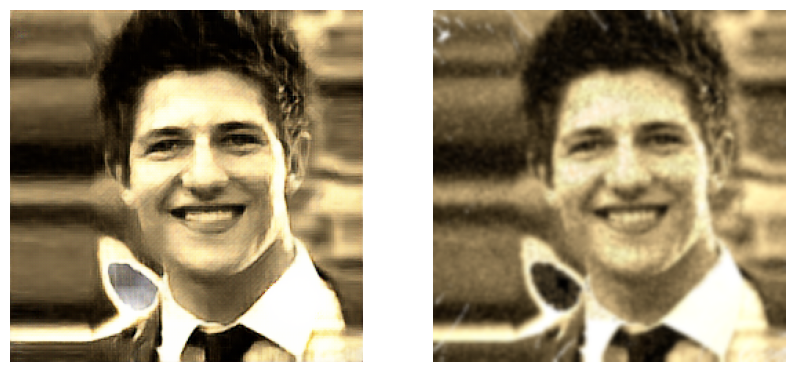

In [214]:
infer_path="/kaggle/input/humanface8000/landscape Images/color/10057.jpg"
res=inference(infer_path,load_gen,True)